# Overview

Functionality implemented so far:
1. Read excel files and plot raw traces of graphs `plot_traces`
2. Find & calculate responding cells & plot average number of responding cells per slide for each cell type `percentage_response`, also combine data from all responding cells from all slides for each cell type
3. Graph max utp response for each slide `max_amp_plot`
4. Statistical significance: p-value and effect size `stats.ttest_ind` and `cohen_d`
5. Plot average values for control groups vs. L89A overexpressed groups `average_plot`
6. Export plots as png files into code folder

TODO's:
** Please open an issue for anything that should be implemented! **
1. Find area under the curve
2. Find max UTP amplitude
3. Find rate of rise


# Code

## Imports

In [1]:
# Import modules for working with excel sheets and for plotting

# matplotlib: module for plotting
# pandas: module for working with dataframe (can be imported from excel, csv, txt)
# %: ipython magic, to plot graphs in line
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
from scipy import stats
%matplotlib inline

In [2]:
# `PLOT' is a global variable that needs to be set to `True' to actually plot things in this notebook
PLOT = True

## Load Data

The following dataset is NOT on GitHub. Make sure your local directory structure is as follows:

                    repository_directory
                     /        \        \
                    /          \        \
                  code        assets    other files (.gitignore, README.md, LICENSE.txt, ...)
                   /            \
                  /              \
    <jupyter_notebook_file>    <data_file>
    
Also, if you want to use the functions in this script with another dataset, make sure to change `number_of_rows` 
and the file name in the following import statements.

In [3]:
# Import excel file as a `pandas.ExcelFile' object (which basically has all sub-sheets in a big container!)
# also, only import 1302 rows
number_of_rows = 2100
ca_data = pd.ExcelFile('../assets/2018-10-11 stable MB231 WTOE L89K  3 uM UTP Ca2+ free.xlsx', nrows=number_of_rows)

## Functions

The following functions are used throughout this notebook to analyze and visualize data.
The doc-string should provide enough information on how they work. 
They basically encapsulate commonly used commands to make re-use easier!

In [4]:
# plot every single trace after reading subsheets and alphabetically sorting them
def plot_traces(df, plot=True):
    """
    this function takes a pandas.io.excel.ExcelFile object and iterates over all sheets
    every column of every such sheet is interpreted as a 'trace' and plotted in a line plot
    a new line plot is created for every sheet in the pandas.io.excel.ExcelFile object
    
    -------------------------a-----
    arguments:
    df        - input data (pandas.io.excel.ExcelFile)
    plot      - defaults to False, if True, plot line plots for every sheet in `df'
    """
    sheetnames = df.sheet_names.copy()
    sheetnames.sort()
    for sheetname in sheetnames: 
        temp = pd.read_excel(df, sheetname)
        if plot:
            f = temp.plot(title=sheetname, legend=False)
            #fig = f.get_figure()
            #fig.savefig(str(sheetname))           
    

In [5]:
# Find percentage of responding cells per slide and create a new dataframe for values that pass threshold
# Find average according to grouping
def percentage_response(df, threshold=1.1, utp_range=(40,600)):
    """
    this function calculates the response rate for calcium imaging data sets
    it takes a pandas.io.excel.ExcelFile and iterates over all data sheets and 
    columns in the input data frames to find the max value within the UTP range
    the max value is then compared with a threshold, if max value >= threshold, then the column is copied to a new data frame
    if value < threshold, value is not coppied to the new dataframe
    return a new data frame is created for each cell types only with columns of data the pass the threshold
    Also calculate % of cells responding per slide and draw a bar plot with 95% ci error bar
    
    ------------------------------
    arguments:
    df        - input data (pandas.io.excel.ExcelFile)
    threshold - defaults to 1.1, the response threshold for your dataset
    utp_range - defaults to (40,600), a tuple indicating the range in which to look 
    verbose   - defaults to False, if True, verbose output is printed (use it to suppress output)
    plot      - defaults to False, if True, plot boxplots to visualize computations
    """
    sheetnames = df.sheet_names.copy()
    sheetnames.sort()
    counter = 0
    col_counter = 0
    appended_data = []
    filtered_data = pd.DataFrame()
     
    for sheetname in sheetnames: 
        selected_df = pd.read_excel(df, sheetname)[utp_range[0]:utp_range[1]]
        complete_df = pd.read_excel(df, sheetname)
        selected_df_max = selected_df.max()
        
        # counter in 1st but not 2nd loop so it's reset to 0 after every sheet but not after every column
        counter = 0
        col_counter = 0
        for idx in selected_df_max.index:
            col_counter += 1
            if selected_df_max[idx] >= threshold:
                placeholder = sheetname + idx
                placeholder2 = placeholder.replace(" ", "")
                new_col_name = placeholder2.replace("W3Avg","")
                temp = {new_col_name: complete_df[idx]} 
                filtered_data = pd.concat([filtered_data, pd.DataFrame(temp)], axis=1)
            else:
                counter = counter + 1 # shorthand for this is: counter += 1, in cool languages (computer languages): counter++
        
        d = {'Genotype': str(sheetname)[0:4], 'Sheetname':[sheetname], 'Total cells':[col_counter], 'Non-responding': [counter],'Percentage responding': [100-(counter*100/col_counter)]}
        
        data=pd.DataFrame(d)
        appended_data.append(data)
        
    appended_data = pd.concat(appended_data,ignore_index=True) 
    print(appended_data)
    writer = pd.ExcelWriter('CTRL_WT_response.xlsx', engine='xlsxwriter')
    appended_data.to_excel(writer, sheet_name='Sheet1')
    writer.save()
    
    ax = sns.barplot(x = 'Genotype', data=appended_data, y="Percentage responding", ci=95).set_title('Percentage of cells responding')
    return filtered_data

## Exploratory Data Analysis (*EDA*)

   Genotype Sheetname  Total cells  Non-responding  Percentage responding
0      L89K     L89K1           56              11              80.357143
1      L89K     L89K2           43               7              83.720930
2      L89K     L89K3           38               2              94.736842
3      L89K     L89K4           41               2              95.121951
4      L89K     L89K5           40               1              97.500000
5      L89K     L89K6           31               2              93.548387
6      WTOE     WTOE1           42               0             100.000000
7      WTOE     WTOE2           47              19              59.574468
8      WTOE     WTOE3           58               8              86.206897
9      WTOE     WTOE4           48               6              87.500000
10     WTOE     WTOE5           46              11              76.086957
11     WTOE     WTOE6           31              14              54.838710


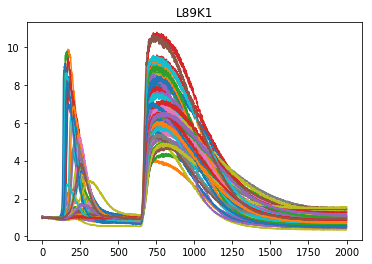

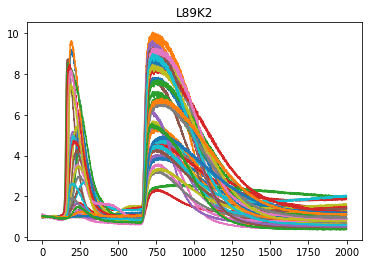

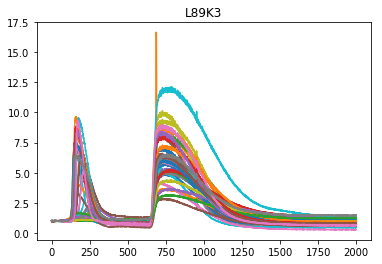

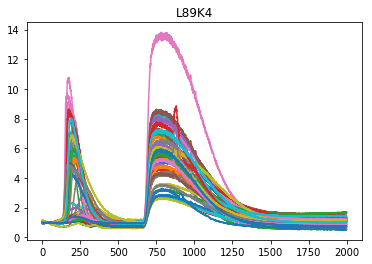

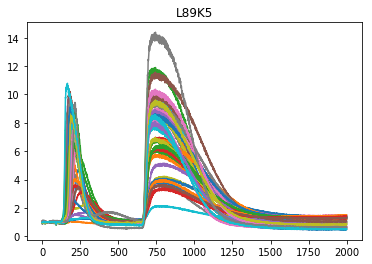

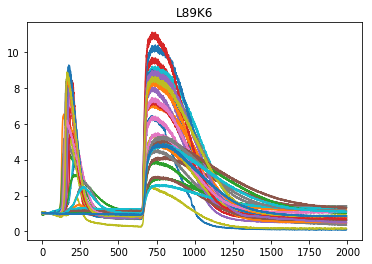

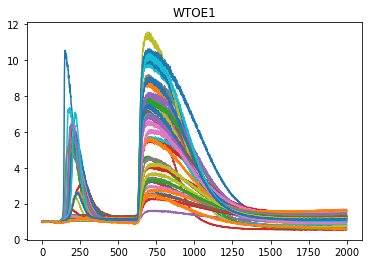

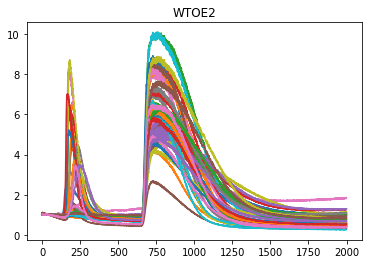

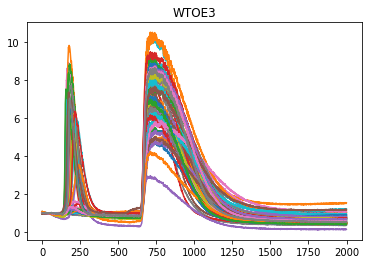

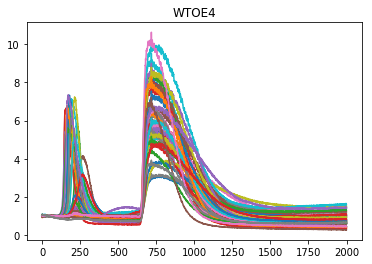

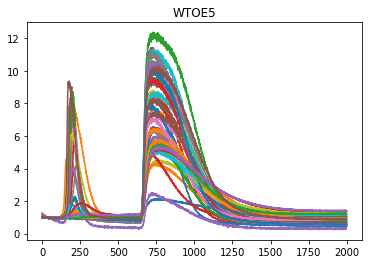

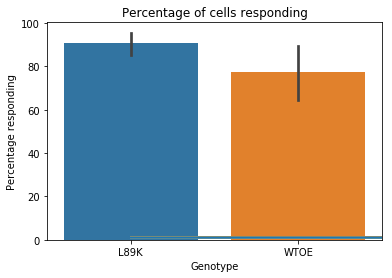

In [6]:
# call the newly created `plot_traces' function (output is suppressed)
plot_traces(df=ca_data, plot=True)

#Plot average number of responding cells per slide for each cell type
filtered_data = percentage_response(ca_data, threshold=1.1, utp_range=(40,600))


In [7]:
#step 1: Make a new empty dataframe outside the for loop
#step 2: To get desired column, [idx] --> type of a panda series
#step 3: 1st reinteration, concatenate new data frame 
#step 4: concatenate with next dataframe



def combined_data(df):
    """
    this function combines data from different 
    coverslips of the same cell type 
    into 1 data frame using regular expression
    
    ------------------------------
    arguments:
    df        - filtered data from `ca_response_rate` function
    """
    column_names = df.columns
    ctrl_data = pd.DataFrame()
    l89a_data = pd.DataFrame()
    l89k_data = pd.DataFrame()
    wtoe_data = pd.DataFrame()
    e120q_data = pd.DataFrame()

    #print(column_names)
    pattern_ctrl = re.compile("CTRL.*")
    pattern_l89a = re.compile("L89A.*")
    pattern_l89k = re.compile("L89K.*")
    pattern_wtoe = re.compile("WTOE.*")
    pattern_e120q = re.compile("E120Q.*")
    for column_name in column_names:
        if pattern_ctrl.match(column_name):
            temp1 = {column_name: filtered_data[column_name]}
            ctrl_data = pd.concat([ctrl_data, pd.DataFrame(temp1)], axis=1)
        if pattern_l89a.match(column_name):
            temp1 = {column_name: filtered_data[column_name]}
            l89a_data = pd.concat([l89a_data, pd.DataFrame(temp1)], axis=1)
        if pattern_l89k.match(column_name):
            temp1 = {column_name: filtered_data[column_name]}
            l89k_data = pd.concat([l89k_data, pd.DataFrame(temp1)], axis=1)
        if pattern_wtoe.match(column_name):
            temp1 = {column_name: filtered_data[column_name]}
            wtoe_data = pd.concat([wtoe_data, pd.DataFrame(temp1)], axis=1)
        if pattern_e120q.match(column_name):
            temp1 = {column_name: filtered_data[column_name]}
            e120q_data = pd.concat([e120q_data, pd.DataFrame(temp1)], axis=1)
        
    return ctrl_data, l89a_data, l89k_data, wtoe_data, e120q_data
            

In [8]:
ctrl_data, l89a_data, l89k_data, wtoe_data, e120q_data = combined_data(df=filtered_data)

In [9]:
def max_amp_plot(df, utp_range=(40, 600), title='none'):
    """
    document me!
    """
    column_names = df.columns
    d = {}
    for column_name in column_names: 
        df_max = df.iloc[utp_range[0]:utp_range[1], :].max()
        #f = df_max.plot.box(title=title) 
        f = sns.barplot(data=df_max, ci=95)
        fig = f.get_figure()
        
    #fig.savefig(str(column_name))  
    

    return df_max


ctrl_max = max_amp_plot(df=ctrl_data, utp_range=(40, 600), title='L89A')


l89a_max = max_amp_plot(df=l89a_data, utp_range=(40, 600), title='L89A')


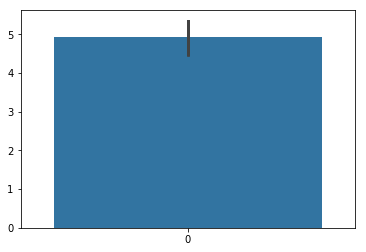

In [22]:
l89k_max = max_amp_plot(df=l89k_data, utp_range=(40, 600), title='L89A')

In [10]:
def make_df(cols, ind):
    """Quickly make a DataFrame"""
    time = (np.linspace(0,499.75,2000))
    data = {c: [str(c) + str(i) for i in time]
            for c in cols}
    return pd.DataFrame(data, ind)

# example DataFrame
time_column = make_df('A', range(2000))
time_column =pd.DataFrame(time_column)
#print(time_column)

In [11]:
# make a list of the header row and strip up to the 4th letter. This is the location and year information
column_name = ctrl_data.columns
genotype = [str(x)[:4] for x in column_name]
coverslip=[str(x)[4:5] for x in column_name]
cell_no=[str(x)[6:] for x in column_name]
time = pd.DataFrame({'Time (s)': np.linspace(0,499.75,2000)})

d = {'Genotype': genotype, 'Coverslip': coverslip, 'Cell number': cell_no}
e = pd.DataFrame(d)
f = time_column.join(ctrl_data)
f = f.set_index('A')
#print(f)
f = f.transpose()
#print(f)
f = f.reset_index()
f = f.drop('index', axis=1)
tidy_ctrl = e.join(f)
#print(tidy_ctrl)

In [12]:
# make a list of the header row and strip up to the 4th letter. This is the location and year information
column_name_l89a = l89a_data.columns
genotype_a = [str(x)[:4] for x in column_name_l89a]
coverslip_a=[str(x)[4:5] for x in column_name_l89a]
cell_no_a=[str(x)[6:] for x in column_name_l89a]

g = {'Genotype': genotype_a, 'Coverslip': coverslip_a, 'Cell number': cell_no_a}
h = pd.DataFrame(g)
i = time_column.join(l89a_data)
i = i.set_index('A')
#print(f)
i = i.transpose()
#print(f)
i = i.reset_index()
i = i.drop('index', axis=1)
tidy_l89a = h.join(i)
#print(tidy_l89a)


In [13]:
# make a list of the header row and strip up to the 4th letter. This is the location and year information
column_name_l89k = l89k_data.columns
genotype_k = [str(x)[:4] for x in column_name_l89k]
coverslip_k=[str(x)[4:5] for x in column_name_l89k]
cell_no_k=[str(x)[6:] for x in column_name_l89k]

z = {'Genotype': genotype_k, 'Coverslip': coverslip_k, 'Cell number': cell_no_k}
v = pd.DataFrame(z)
x = time_column.join(l89k_data)
x = x.set_index('A')
#print(f)
x = x.transpose()
#print(f)
x = x.reset_index()
x = x.drop('index', axis=1)
tidy_l89k = v.join(x)
#print(tidy_l89a)


In [14]:
# make a list of the header row and strip up to the 4th letter. This is the location and year information
column_name_wtoe = wtoe_data.columns
genotype_wt = [str(x)[:4] for x in column_name_wtoe]
coverslip_wt=[str(x)[4:5] for x in column_name_wtoe]
cell_no_wt=[str(x)[6:] for x in column_name_wtoe]

z = {'Genotype': genotype_wt, 'Coverslip': coverslip_wt, 'Cell number': cell_no_wt}
v = pd.DataFrame(z)
x = time_column.join(wtoe_data)
x = x.set_index('A')
#print(f)
x = x.transpose()
#print(f)
x = x.reset_index()
x = x.drop('index', axis=1)
tidy_wtoe = v.join(x)
#print(tidy_l89a)


In [15]:
# make a list of the header row and strip up to the 4th letter. This is the location and year information
column_name_e120q = e120q_data.columns
genotype_eq = [str(x)[:5] for x in column_name_e120q]
coverslip_eq=[str(x)[6:6] for x in column_name_e120q]
cell_no_eq=[str(x)[7:] for x in column_name_e120q]

z = {'Genotype': genotype_eq, 'Coverslip': coverslip_eq, 'Cell number': cell_no_eq}
v = pd.DataFrame(z)
x = time_column.join(e120q_data)
x = x.set_index('A')
#print(f)
x = x.transpose()
#print(f)
x = x.reset_index()
x = x.drop('index', axis=1)
tidy_e120q = v.join(x)
#print(tidy_l89a)

In [16]:
total_data = pd.concat([tidy_ctrl, tidy_l89a, tidy_l89k, tidy_wtoe, tidy_e120q], axis=0, ignore_index=True)
tidy = pd.DataFrame()
times = pd.DataFrame({'Time (s)': np.linspace(0,499.75,2000)})
for i, row in total_data.iterrows():
    #print('this is a new row')
    temp1 = total_data.iloc[i:i+1, 0:3]
    temp2 = pd.concat([temp1]*2000, ignore_index=True)
    temp3 = time.join(temp2, sort=True)
    
    temp4 = total_data.iloc[i:i+1, 3:2004]
    temp5 = temp4.T
    temp6 = temp5.reset_index()
    temp7 = temp6.rename(columns = {temp6.columns[1]: 'F/Fo'})
    temp8 = temp7.iloc[:,1]
    temp9 = temp3.join(temp8)
    tidy = pd.concat([tidy, temp9], ignore_index=True)

In [17]:
tidy.tail()

,Time (s),Genotype,Coverslip,Cell number,F/Fo
875995,498.75,WTOE,6,31,0.627924
875996,499.00,WTOE,6,31,0.597348
875997,499.25,WTOE,6,31,0.643560
875998,499.50,WTOE,6,31,0.649931
875999,499.75,WTOE,6,31,0.599259


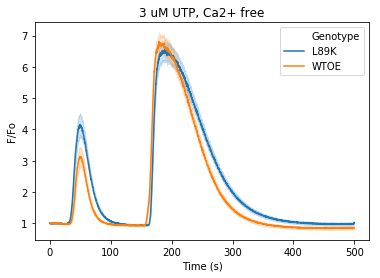

In [18]:
ax = sns.lineplot(x="Time (s)", y="F/Fo", hue="Genotype", ci=95, data=tidy).set_title('3 uM UTP, Ca2+ free')
fig = ax.get_figure()
fig.savefig("All cells")

In [19]:
writer = pd.ExcelWriter('CTRL_WT.xlsx', engine='xlsxwriter')
tidy.to_excel(writer, sheet_name='Sheet1')
writer.save()

KeyboardInterrupt: 